#### 전복 분류를 CNN으로 구현하고
#### 
모델을 저장한 후에,#### 

사전학습 모델로 불러서 새로운 층과 출력층을 추가#### 하고

미세조정 fine-tunning

# 데이터 불러오기 및 전처리

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('C:/Users/USER/Desktop/Deep_Learning/abalone.csv')
df

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [203]:
df.info()

# 모든 행이 non_null로 이상치는 없는거 같다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4177 non-null   int64  
 1   Sex             4177 non-null   object 
 2   Length          4177 non-null   float64
 3   Diameter        4177 non-null   float64
 4   Height          4177 non-null   float64
 5   Whole_weight    4177 non-null   float64
 6   Shucked_weight  4177 non-null   float64
 7   Viscera_weight  4177 non-null   float64
 8   Shell_weight    4177 non-null   float64
 9   Rings           4177 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 326.5+ KB


In [205]:
df.isnull().values.any()

False

##### 성별 분류 진행

In [208]:
df['Sex'].value_counts()

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

Text(0, 0.5, 'Count')

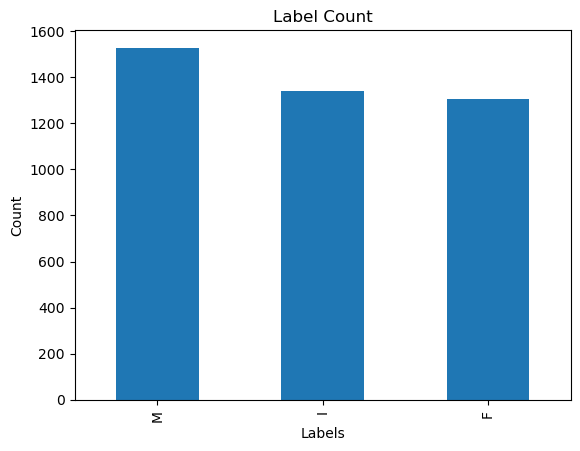

In [210]:
# 레이블별 갯수 확인
label_counts = df['Sex'].value_counts()

# 바 그래프 그리기
label_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Label Count')
plt.xlabel('Labels')
plt.ylabel('Count')

In [211]:
# 분류
input_cls = df.drop(['id','Sex'],axis=1).values
target_cls = df['Sex']

In [212]:
# one hot encoding
target_cls=pd.get_dummies(target_cls).astype(int)
target_cls.values

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [213]:
# split test and train set
from sklearn.model_selection import train_test_split
x_train_cls,x_test_cls,y_train_cls,y_test_cls = train_test_split(input_cls,target_cls,test_size=0.2,shuffle=True,random_state=12)

x_train_cls.shape,x_test_cls.shape,y_train_cls.shape,y_test_cls.shape

((3341, 8), (836, 8), (3341, 3), (836, 3))

### 데이터 전처리

In [215]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_cls = sc.fit_transform(x_train_cls)
x_test_cls = sc.transform(x_test_cls)

x_train_cls.shape

(3341, 8)

#### 

#### 현재 input 차원은 2차원 인데 CNN 모델은 최소 3차원 데이터 부터 입력데이터로 들어가야함 Conv1D는(배치 크기, 시퀀스 길이, 특성 수) 형식으로 들어감 (3341,1,8) Conv2D라면 (배치 크기, 높이, 너비, 채널 수) (3341,9,1,1) 로!

In [218]:
x_train_cls = x_train_cls.reshape(x_train_cls.shape[0],1,x_train_cls.shape[1])
x_test_cls = x_test_cls.reshape(x_test_cls.shape[0],1,x_test_cls.shape[1])
x_train_cls.shape, x_test_cls.shape

((3341, 1, 8), (836, 1, 8))

# 1. CNN 모델 구성

In [220]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def cnn_model(input_shape):
    model = Sequential()
    # kernel_size를 시퀀스 길이보다 작게 설정
    model.add(Conv1D(32,kernel_size=1,activation='relu',input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(3,activation='softmax'))

    return model

input_shape = (1,x_train_cls.shape[2])
model = cnn_model(input_shape)

model.summary()

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 1, 32)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,899 (19.14 KB)

 Trainable params: 4,899 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

In [223]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [227]:
history = model.fit(x_train_cls,y_train_cls,epochs=30,validation_split=0.2)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4962 - loss: 0.9545 - val_accuracy: 0.5680 - val_loss: 0.8382
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5521 - loss: 0.8775 - val_accuracy: 0.5740 - val_loss: 0.8246
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5356 - loss: 0.8800 - val_accuracy: 0.5441 - val_loss: 0.8301
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5616 - loss: 0.8582 - val_accuracy: 0.5561 - val_loss: 0.8180
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5712 - loss: 0.8542 - val_accuracy: 0.5874 - val_loss: 0.8130
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5601 - loss: 0.8593 - val_accuracy: 0.5889 - val_loss: 0.8103
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5639 - loss: 0.8541 - val_accuracy: 0.5904 - val_loss: 0.8077
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5646 - loss: 0.8492 - val_accuracy: 0.5845 - val_loss:

In [228]:
# loss 시각화
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

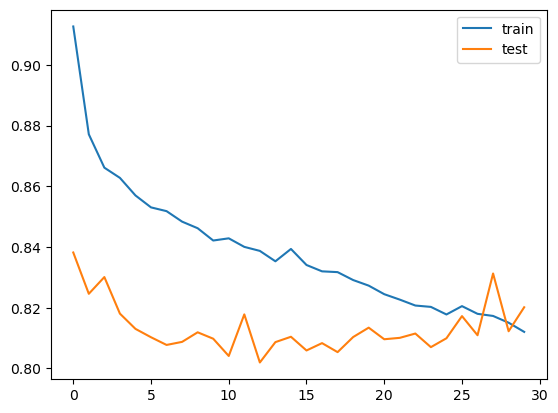

In [230]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

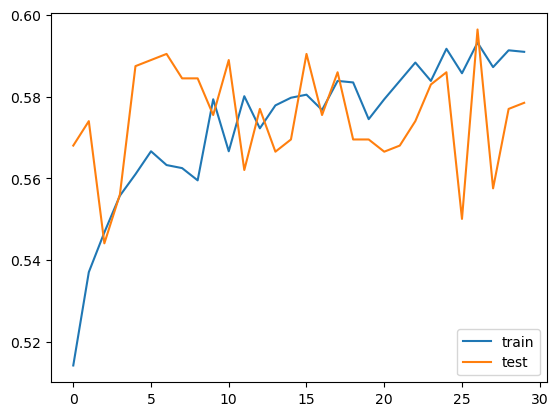

In [232]:
# 정확도
plt.plot(history.history["accuracy"],label="train")
plt.plot(history.history["val_accuracy"],label="test")
plt.legend()

In [233]:
model.evaluate(x_test_cls,y_test_cls)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5806 - loss: 0.8471


[0.8215692639350891, 0.5765550136566162]

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix


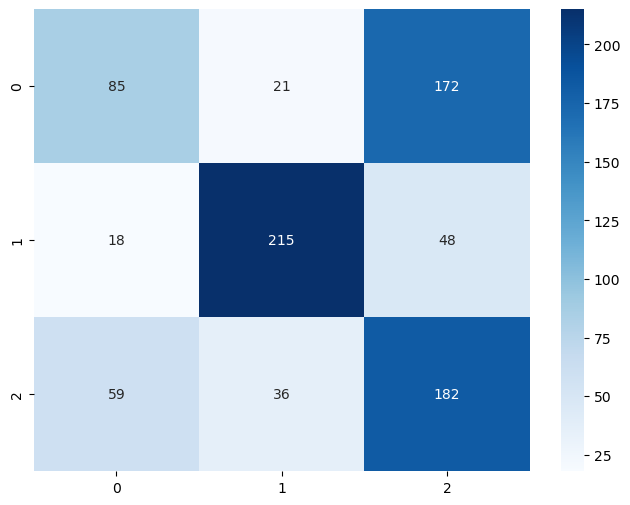

In [235]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_cls, axis=1)
Y_pred = np.argmax(model.predict(x_test_cls),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()

# 2. 사전 학습 모델로 저장

In [237]:
import tensorflow as tf

base_loss,base_accuracy=model.evaluate(x_test_cls, y_test_cls)

model_file='.abalone.h5'

tf.keras.models.save_model(model, model_file, include_optimizer=False)
print('model saved at ', model_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5806 - loss: 0.8471


model saved at  .abalone.h5
Accuracy >57.655501
Base Loss >0.82


# 3.  사전 학습 모델 불러와서 새로운 층과 출력층 추가하기

In [239]:
from tensorflow.keras.models import load_model

base_model = load_model(model_file)

In [240]:
base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(x_test_cls, y_test_cls)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5806 - loss: 0.8471   


[0.8215692639350891, 0.5765550136566162]

In [241]:
base_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 1, 32)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,899 (19.14 KB)

 Trainable params: 4,899 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

In [242]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  5


In [243]:
from tensorflow.keras import layers, models

def remove_last_layers(model, num_layers_to_remove):
    # 모델의 레이어를 하나씩 슬라이스해서 앞의 레이어만 가져옴
    model_layers = model.layers[:-num_layers_to_remove]  # 마지막 레이어부터 지정된 갯수만큼 제외
    new_model = models.Sequential(model_layers)  # 새로운 모델에 해당 레이어들만 추가
    return new_model

In [244]:
# 출력층부터 1개의 레이어를 삭제
new_model = remove_last_layers(base_model, 3)

In [245]:
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 1, 32)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288 (1.12 KB)

 Trainable params: 288 (1.12 KB)

 Non-trainable params: 0 (0.00 B)

In [246]:
# 새로운 층으로 Conv1D 층과 Dense층 추가하고 출력층 추가

new_model.add(Conv1D(64,kernel_size=1,activation='relu'))
new_model.add(MaxPooling1D(pool_size=1))
new_model.add(Flatten())
new_model.add(Dense(32,activation='relu'))
new_model.add(Dense(3,activation='softmax'))

In [247]:
new_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 1, 32)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288 (1.12 KB)

 Trainable params: 288 (1.12 KB)

 Non-trainable params: 0 (0.00 B)

In [248]:
history2 = new_model.fit(x_train_cls,y_train_cls,epochs=30,validation_data=(x_test_cls,y_test_cls))

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5172 - loss: 0.9635 - val_accuracy: 0.5586 - val_loss: 0.8401
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5525 - loss: 0.8658 - val_accuracy: 0.5478 - val_loss: 0.8283
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5546 - loss: 0.8519 - val_accuracy: 0.5562 - val_loss: 0.8187
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5677 - loss: 0.8388 - val_accuracy: 0.5646 - val_loss: 0.8126
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5721 - loss: 0.8399 - val_accuracy: 0.5538 - val_loss: 0.8185
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5649 - loss: 0.8276 - val_accuracy: 0.5467 - val_loss: 0.8232
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5748 - loss: 0.8321 - val_accuracy: 0.5706 - val_loss: 0.8076
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5753 - loss: 0.8152 - val_accuracy: 0.

In [249]:
new_model.evaluate(x_test_cls,y_test_cls)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5735 - loss: 0.8477


[0.8157750368118286, 0.5801435112953186]

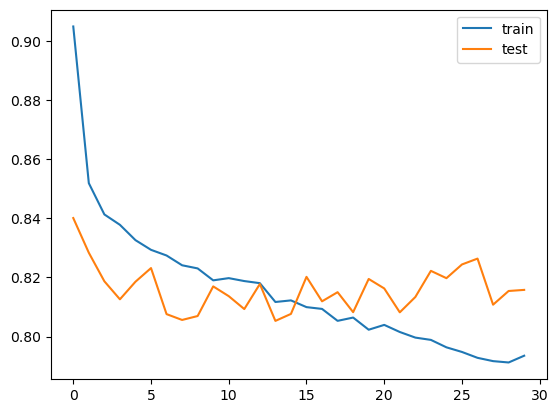

In [250]:
plt.plot(history2.history["loss"], label = "train")
plt.plot(history2.history["val_loss"], label = "test")
plt.legend()

##### 과대적합 

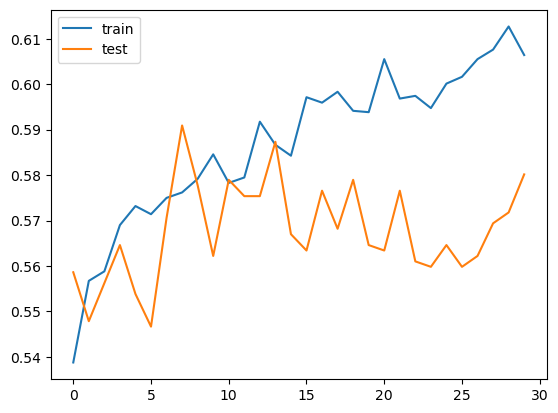

In [252]:
plt.plot(history2.history["accuracy"],label="train")
plt.plot(history2.history["val_accuracy"],label="test")
plt.legend()

# 4. Fine tunning

In [254]:
base_model.trainable = True

In [255]:
new_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
display_layers = [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<Conv1D name=conv1d_7, built=True>",conv1d_7,True
1,"<MaxPooling1D name=max_pooling1d_4, built=True>",max_pooling1d_4,True
2,"<Conv1D name=conv1d_8, built=True>",conv1d_8,True
3,"<MaxPooling1D name=max_pooling1d_5, built=True>",max_pooling1d_5,True
4,"<Flatten name=flatten_5, built=True>",flatten_5,True
5,"<Dense name=dense_10, built=True>",dense_10,True
6,"<Dense name=dense_11, built=True>",dense_11,True


In [256]:
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 1, 32)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 1, 64)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,579 (17.89 KB)

 Trainable params: 4,579 (17.89 KB)

 Non-trainable params: 0 (0.00 B)

In [257]:
history3 = new_model.fit(x_train_cls,y_train_cls,epochs=30,validation_data=(x_test_cls,y_test_cls),shuffle=True)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6046 - loss: 0.7889 - val_accuracy: 0.5502 - val_loss: 0.8381
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5981 - loss: 0.7995 - val_accuracy: 0.5718 - val_loss: 0.8211
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6133 - loss: 0.8003 - val_accuracy: 0.5718 - val_loss: 0.8166
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6171 - loss: 0.7754 - val_accuracy: 0.5562 - val_loss: 0.8313
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6208 - loss: 0.7728 - val_accuracy: 0.5598 - val_loss: 0.8378
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6191 - loss: 0.7839 - val_accuracy: 0.5622 - val_loss: 0.8276
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6159 - loss: 0.7784 - val_accuracy: 0.5682 - val_loss: 0.8293
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6267 - loss: 0.7919 - val_accuracy: 0.

In [258]:
new_model.evaluate(x_test_cls,y_test_cls)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.8668


[0.8440142273902893, 0.5586124658584595]

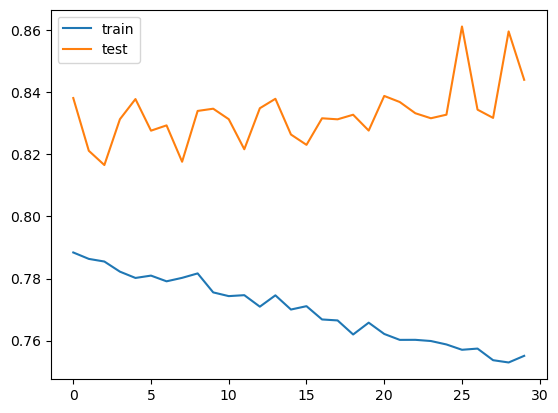

In [259]:
plt.plot(history3.history["loss"], label = "train")
plt.plot(history3.history["val_loss"], label = "test")
plt.legend()

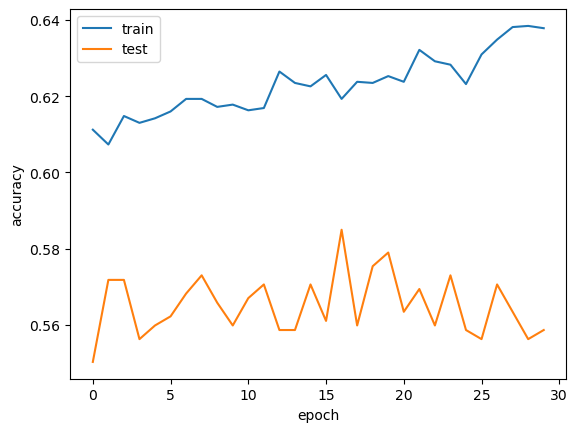

In [260]:
plt.plot(history3.history["accuracy"],label="train")
plt.plot(history3.history["val_accuracy"],label="test")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

### Dropout, BatchNormalization 추가

In [262]:
from tensorflow.keras.layers import Dropout, BatchNormalization

new_model.add(Dropout(0.5))
new_model.add(Conv1D(64,kernel_size=1,activation='relu'))
new_model.add(BatchNormalization())
new_model.add(MaxPooling1D(pool_size=1))
new_model.add(Dropout(0.5))

new_model.add(Flatten())
new_model.add(Dense(64,activation='relu'))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.5))
new_model.add(Dense(3,activation='softmax'))

new_model.summary()

ValueError: Input 0 of layer "conv1d_9" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 3)

In [263]:
new_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [265]:
history4 = new_model.fit(x_train_cls,y_train_cls,epochs=30,validation_data=(x_test_cls,y_test_cls),shuffle=True)


Epoch 1/30


ValueError: Input 0 of layer "conv1d_9" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 3)

In [267]:
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 1, 32)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 1, 64)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,579 (17.89 KB)

 Trainable params: 4,579 (17.89 KB)

 Non-trainable params: 0 (0.00 B)

In [269]:
new_model.evaluate(x_test_cls,y_test_cls)

ValueError: Input 0 of layer "conv1d_9" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 3)

In [271]:
new_model.evaluate(x_train,y_train)

NameError: name 'x_train' is not defined

In [273]:
plt.plot(history4.history["loss"], label = "train")
plt.plot(history4.history["val_loss"], label = "test")
plt.legend()

NameError: name 'history4' is not defined

In [275]:
plt.plot(history4.history["accuracy"],label="train")
plt.plot(history4.history["val_accuracy"],label="test")
plt.legend()

NameError: name 'history4' is not defined

# LSTM 모델 분류

##### 시계열 데이터로 전처리

In [279]:
from collections import Counter

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # 시퀀스의 끝 인덱스 계산
        end_ix = i + n_steps
        if end_ix > len(sequences):  # 데이터 범위를 넘으면 종료
            break
        
        # 입력과 출력 데이터를 추출
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터
        seq_y_values = sequences[i:end_ix, -1]  # 해당 구간의 레이블들

        # 가장 빈번한 레이블을 선택
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]

        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가

    return np.array(X), np.array(y)  # Numpy 배열로 변환하여 반환

In [281]:
# 시계열 데이터로 만들기 위해서 데이터 전처리 과정에서 train test x/y로 나눴는데 
# y(target)을 x(input) 뒤에 붙여줘야 이 함수가 작동함. 시계열에 맞는 새로운 label이 필요하기 때문!

y_train_arr = np.array(y_train_cls)
train_set = np.c_[x_train_cls,y_train_arr]

y_test_arr = np.array(y_test_cls)
test_set = np.c_[x_test_cls,y_test_arr]

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [283]:
n_step = 4

x_train_timeseries , y_train_timeseries = split_sequences(train_set,n_step)
print(x_train_timeseries.shape,y_train_timeseries.shape)

x_test_timeseries , y_test_timeseries = split_sequences(test_set,n_step)
print(x_test_timeseries.shape,y_test_timeseries.shape)

NameError: name 'train_set' is not defined